In [1]:
# %matplotlib qt 

# %matplotlib inline

import typing as T

import numpy as np
import numpy.typing as npt
import scipy as sp

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

from pydrake.solvers import (  
    MathematicalProgram,
    MathematicalProgramResult,
    Solve,
)
from pydrake.symbolic import Polynomial, Variable, Variables

from util import timeit

FREE_POLY = "free_poly"
PSD_POLY = "psd_poly"
PSD_ON_REGION_POLY = "psd_on_region"

In [2]:
%matplotlib widget

In [3]:
class Vertex:
    def __init__(self, name:str, prog: MathematicalProgram, lb:npt.NDArray, ub:npt.NDArray, potential_poly_deg=2, multiplier_deg = 4, pot_type=FREE_POLY):
        self.lb = lb
        self.ub = ub
        self.n = len(lb)
        assert len(ub) == self.n
        self.name = name
        self.potential_poly_deg = potential_poly_deg
        self.multiplier_deg = multiplier_deg
        
        self.define_variables(prog)
        self.define_set_vector()
        self.define_potential(prog, pot_type )

    def define_variables(self, prog: MathematicalProgram):
        self.x = prog.NewIndeterminates(self.n, "x_" + self.name)
        self.vars = Variables(self.x)

    def define_potential(self, prog: MathematicalProgram, pot_type:str):
        # potential is a free polynomial
        if pot_type == FREE_POLY:
            self.potential = prog.NewFreePolynomial(self.vars, self.potential_poly_deg)
        elif pot_type == PSD_POLY:
            # potential is PSD polynomial
            self.potential, _ = prog.NewSosPolynomial(self.vars, self.potential_poly_deg)
        elif pot_type == PSD_ON_REGION_POLY:
            # potential is PSD on its region
            self.potential = prog.NewFreePolynomial(self.vars, self.potential_poly_deg)
            multiplier1, _ = prog.NewSosPolynomial(self.vars, self.multiplier_deg)
            multiplier2, _ = prog.NewSosPolynomial(self.vars, self.multiplier_deg)
            multipliers = np.array([multiplier1, multiplier2])
            prog.AddSosConstraint( self.potential + multipliers.dot(self.convex_set_poly) )

    def define_set_vector(self):
        # represent using a square
        # i want a function g that's only negative on the box
        # (x - x_min)*(x - x_max) <= fits the description
        self.convex_set_poly = []
        for i in range(self.n):
            x_min, x_max, x = self.lb[i], self.ub[i], self.x[i]
            self.convex_set_poly.append( Polynomial((x - x_min)*(x - x_max)) )
        self.convex_set_poly = np.array(self.convex_set_poly)

    def evaluate_partial_potential_at_point(self, x:npt.NDArray):
        assert len(x) == self.n
        return self.potential.EvaluatePartial( { self.x[i]: x[i] for i in range(self.n) } )
    
    def cost_at_point(self, x:npt.NDArray, solution:MathematicalProgramResult=None):
        if solution is None:
            return self.evaluate_partial_potential_at_point(x).ToExpression()
        else: 
            return solution.GetSolution(self.potential).Evaluate( { self.x[i]: x[i] for i in range(self.n) } )

    def cost_at_center(self, solution:MathematicalProgramResult = None):
        x = 0.5*(self.lb+self.ub)
        return self.cost_at_point(x, solution)
    
    def cost_of_integral(self, solution:MathematicalProgramResult=None):
        poly = self.potential
        for i in range(self.n):
            x_min, x_max, x = self.lb[i], self.ub[i], self.x[i]
            integral_of_poly = poly.Integrate(x)
            poly = integral_of_poly.EvaluatePartial({x:x_max}) - integral_of_poly.EvaluatePartial({x:x_min})

        if solution is None:
            return poly.ToExpression()
        else:
            return solution.GetSolution(poly)
        
    def cost_of_small_integral_at_center(self, solution:MathematicalProgramResult=None):
        eps = 0.001
        poly = self.potential
        for i in range(self.n):
            x_min, x_max, x = (self.lb[i]+self.ub[i])/2-eps, (self.lb[i]+self.ub[i])/2+eps, self.x[i]
            integral_of_poly = poly.Integrate(x)
            poly = integral_of_poly.EvaluatePartial({x:x_max}) - integral_of_poly.EvaluatePartial({x:x_min})

        if solution is None:
            return poly.ToExpression()
        else:
            return solution.GetSolution(poly)


class Edge:
    def __init__(self, v_left: Vertex, v_right: Vertex, prog: MathematicalProgram, multiplier_deg = 4):
        self.left = v_left
        self.right = v_right
        self.left_right_multiplier_degrees = multiplier_deg
        self.n = self.left.n
        assert self.right.n == self.n

        self.define_quadratic_cost_poly()
        self.define_multipliers(prog)
        self.add_edge_potential_diff_constraint(prog)

    def define_quadratic_cost_poly(self):
        self.edge_cost = Polynomial( sum([  (self.left.x[i]-self.right.x[i])**2 for i in range(self.n)  ]) )

    def define_multipliers(self, prog: MathematicalProgram):
        polys = []
        for i in range(self.n):
            poly,_ = prog.NewSosPolynomial(self.left.vars, self.left_right_multiplier_degrees)
            polys.append(poly)
        self.left_multipliers = np.array(polys)

        polys = []
        for i in range(self.n):
            poly,_ = prog.NewSosPolynomial(self.right.vars, self.left_right_multiplier_degrees)
            polys.append(poly)
        self.right_multipliers = np.array(polys)

    def add_edge_potential_diff_constraint(self, prog: MathematicalProgram):
        expr = (
            self.edge_cost
            - (self.left.potential - self.right.potential)
            + self.left_multipliers.dot(self.left.convex_set_poly)
            + self.right_multipliers.dot(self.right.convex_set_poly) 
        )
        poly, _ = prog.NewSosPolynomial(Variables(np.hstack((self.left.x, self.right.x))), self.left_right_multiplier_degrees)
        prog.AddEqualityConstraintBetweenPolynomials(expr, poly)

        # prog.AddSosConstraint(expr)


In [4]:
eps = 0.001
def make_problem(n, num_vertices, potential_poly_deg, multiplier_deg):
    prog = MathematicalProgram()
    vertices = []
    vt = Vertex("t", prog, -eps*np.ones(n), eps*np.ones(n), potential_poly_deg, multiplier_deg)
    vertices.append( vt )
    for i in range(num_vertices):
        vertices.append(
            Vertex("v"+str(i), prog, (2*i+1)*np.ones(n), (2*i+2)*np.ones(n), potential_poly_deg, multiplier_deg)
        )

    vs = Vertex("s", prog, (2*n+1)*np.ones(n), (2*n+2)*np.ones(n), potential_poly_deg, multiplier_deg)
    vertices.append( vs )

    for i in range( len(vertices)-1 ):
        Edge( vertices[i+1], vertices[i], prog,  multiplier_deg)

    prog.AddEqualityConstraintBetweenPolynomials(vt.evaluate_partial_potential_at_point(np.zeros(n)), Polynomial(0) )
    cost = vs.cost_at_center()
    prog.AddLinearCost( -cost )
    return prog
    

In [30]:
# more and more vertices
n = 3
nv = list(range(1,30))
# num_vertices = 3
potential_poly_deg = 2
multiplier_deg = 4

times = []
for num_vertices in nv:
    prog = make_problem(n, num_vertices, potential_poly_deg, multiplier_deg)
    timer = timeit()
    solution = Solve(prog)
    dt = timer.dt(print_stuff=False)
    print(str(num_vertices) + " " + str(solution.is_success()) + " " + str(dt))
    times.append(dt)

1 True 0.08186817169189453
2 True 0.11072993278503418
3 True 0.1347188949584961
4 True 0.19114017486572266
5 True 0.2505826950073242
6 True 0.2856776714324951
7 True 0.6534440517425537
8 True 0.6657147407531738
9 True 0.8200700283050537
10 True 1.311415672302246
11 True 1.0130739212036133
12 True 1.2695631980895996
13 True 1.5799007415771484
14 True 1.064478874206543
15 True 1.557286262512207
16 True 1.0236737728118896
17 True 1.7356600761413574
18 True 1.9917609691619873
19 True 1.9801430702209473
20 True 2.0691168308258057
21 True 2.4956350326538086
22 True 2.314141273498535
23 True 1.9811761379241943
24 True 2.0579261779785156
25 True 1.6558630466461182
26 True 2.897588014602661
27 True 2.5164458751678467
28 True 2.8321940898895264
29 True 2.7094380855560303


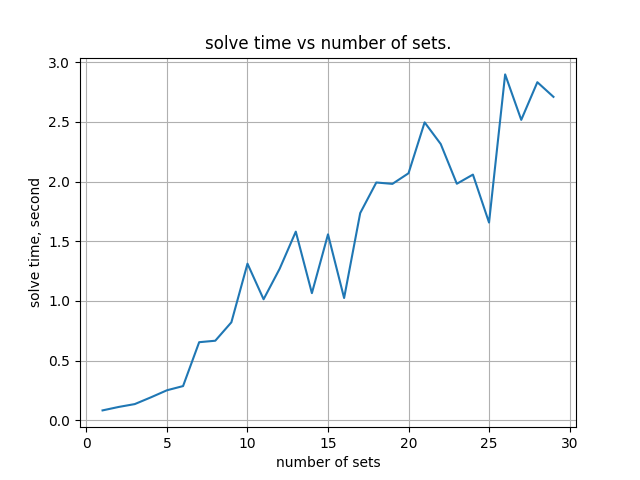

In [38]:
fig, ax = plt.subplots()
ax.plot(nv, times)
ax.set_xlabel("number of sets")
ax.set_ylabel("solve time, second")
ax.set_title("solve time vs number of sets.")
ax.grid()
# state dim = 3
# potential dim = 2

In [6]:
# more and more vertices
ns = list(range(1,8))
num_vertices = 6
potential_poly_deg = 2
multiplier_deg = 4

times = []
for n in ns:
    prog = make_problem(n, num_vertices, potential_poly_deg, multiplier_deg)
    timer = timeit()
    solution = Solve(prog)
    dt = timer.dt(print_stuff=False)
    print(str(n) + " " + str(solution.is_success()) + " " + str(dt))
    times.append(dt)

1 True 0.030866146087646484
2 True 0.06355500221252441
3 True 0.2781078815460205
4 False 0.48305511474609375
5 True 5.167762041091919
6 True 16.101431131362915


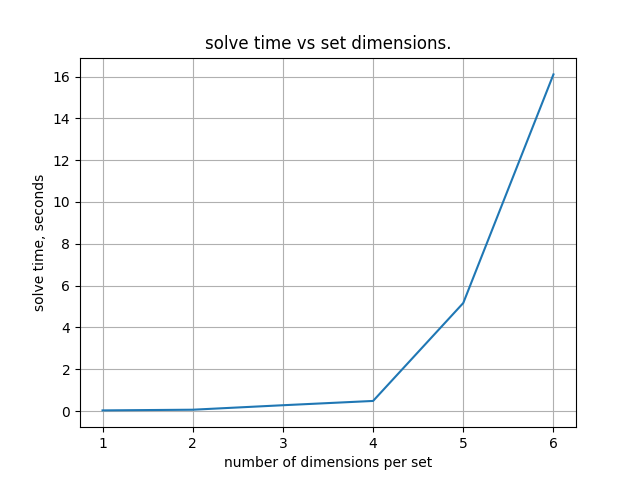

In [9]:
fig, ax = plt.subplots()
ax.plot(ns, times)
ax.set_xlabel("number of dimensions per set")
ax.set_ylabel("solve time, seconds")
ax.set_title("solve time vs set dimensions.")
ax.grid()

In [17]:
# more and more vertices
n = 2
num_vertices = 3
potential_poly_degs = list(range(0,8))

times = []
for potential_poly_deg in potential_poly_degs:
    prog = make_problem(n, num_vertices, potential_poly_deg, potential_poly_deg*2)
    timer = timeit()
    solution = Solve(prog)
    dt = timer.dt(print_stuff=False)
    print(str(potential_poly_deg) + " " + str(solution.is_success()) + " " + str(dt))
    times.append(dt)

0 False 0.0888528823852539Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-25

1 True 0.030425071716308594
2 True 0.0344691276550293
3 True 0.4652407169342041
4 False 0.8327927589416504
5 False 2.705782175064087
6 False 6.032334804534912
7 False 24.96071696281433


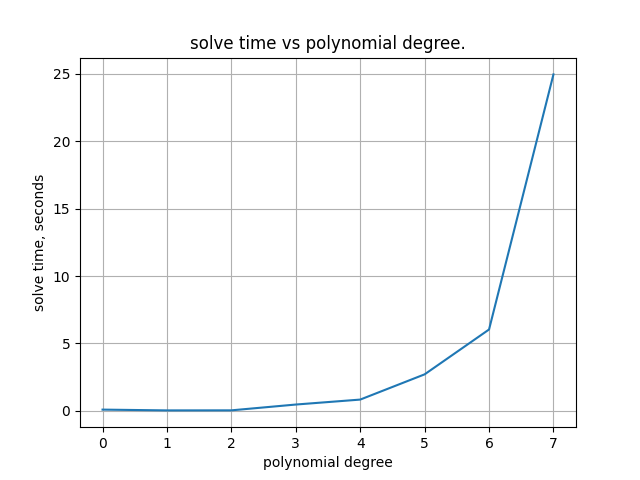

In [18]:
fig, ax = plt.subplots()
ax.plot(potential_poly_degs, times)
ax.set_xlabel("polynomial degree")
ax.set_ylabel("solve time, seconds")
ax.set_title("solve time vs polynomial degree.")
ax.grid()